<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
# default_exp models.gradtts

In [ ]:
# export
import random
import math

from einops import rearrange

import numpy as np
import torch
import torch.nn.functional as F

from uberduck_ml_dev.models.base import TTSModel
from uberduck_ml_dev.vendor.tfcompat.hparam import HParams
from uberduck_ml_dev.text.symbols import SYMBOL_SETS
from uberduck_ml_dev.text.util import text_to_sequence, text_to_sequence_for_editts
from uberduck_ml_dev.utils.utils import intersperse, intersperse_emphases

In [3]:
# export


class BaseModule(torch.nn.Module):
    def __init__(self):
        super(BaseModule, self).__init__()

    @property
    def nparams(self):
        """
        Returns number of trainable parameters of the module.
        """
        num_params = 0
        for name, param in self.named_parameters():
            if param.requires_grad:
                num_params += np.prod(param.detach().cpu().numpy().shape)
        return num_params

    def relocate_input(self, x: list):
        """
        Relocates provided tensors to the same device set for the module.
        """
        device = next(self.parameters()).device
        for i in range(len(x)):
            if isinstance(x[i], torch.Tensor) and x[i].device != device:
                x[i] = x[i].to(device)
        return x

In [4]:
# export


class Mish(BaseModule):
    def forward(self, x):
        return x * torch.tanh(torch.nn.functional.softplus(x))


class Upsample(BaseModule):
    def __init__(self, dim):
        super(Upsample, self).__init__()
        self.conv = torch.nn.ConvTranspose2d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Downsample(BaseModule):
    def __init__(self, dim):
        super(Downsample, self).__init__()
        self.conv = torch.nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Rezero(BaseModule):
    def __init__(self, fn):
        super(Rezero, self).__init__()
        self.fn = fn
        self.g = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.fn(x) * self.g


class Block(BaseModule):
    def __init__(self, dim, dim_out, groups=8):
        super(Block, self).__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(dim, dim_out, 3, padding=1),
            torch.nn.GroupNorm(groups, dim_out),
            Mish(),
        )

    def forward(self, x, mask):
        output = self.block(x * mask)
        return output * mask


class ResnetBlock(BaseModule):
    def __init__(self, dim, dim_out, time_emb_dim, groups=8):
        super(ResnetBlock, self).__init__()
        self.mlp = torch.nn.Sequential(Mish(), torch.nn.Linear(time_emb_dim, dim_out))

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        if dim != dim_out:
            self.res_conv = torch.nn.Conv2d(dim, dim_out, 1)
        else:
            self.res_conv = torch.nn.Identity()

    def forward(self, x, mask, time_emb):
        h = self.block1(x, mask)
        h += self.mlp(time_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.block2(h, mask)
        output = h + self.res_conv(x * mask)
        return output


class LinearAttention(BaseModule):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = torch.nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = torch.nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(
            qkv, "b (qkv heads c) h w -> qkv b heads c (h w)", heads=self.heads, qkv=3
        )
        k = k.softmax(dim=-1)
        context = torch.einsum("bhdn,bhen->bhde", k, v)
        out = torch.einsum("bhde,bhdn->bhen", context, q)
        out = rearrange(
            out, "b heads c (h w) -> b (heads c) h w", heads=self.heads, h=h, w=w
        )
        return self.to_out(out)


class Residual(BaseModule):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        output = self.fn(x, *args, **kwargs) + x
        return output


class SinusoidalPosEmb(BaseModule):
    def __init__(self, dim):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim

    def forward(self, x, scale=1000):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device).float() * -emb)
        emb = scale * x.unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class GradLogPEstimator2d(BaseModule):
    def __init__(
        self,
        dim,
        dim_mults=(1, 2, 4),
        groups=8,
        n_spks=None,
        spk_emb_dim=64,
        n_feats=80,
        pe_scale=1000,
    ):
        super(GradLogPEstimator2d, self).__init__()
        self.dim = dim
        self.dim_mults = dim_mults
        self.groups = groups
        self.n_spks = n_spks if not isinstance(n_spks, type(None)) else 1
        self.spk_emb_dim = spk_emb_dim
        self.pe_scale = pe_scale

        if n_spks > 1:
            self.spk_mlp = torch.nn.Sequential(
                torch.nn.Linear(spk_emb_dim, spk_emb_dim * 4),
                Mish(),
                torch.nn.Linear(spk_emb_dim * 4, n_feats),
            )
        self.time_pos_emb = SinusoidalPosEmb(dim)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(dim, dim * 4), Mish(), torch.nn.Linear(dim * 4, dim)
        )

        dims = [2 + (1 if n_spks > 1 else 0), *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        self.downs = torch.nn.ModuleList([])
        self.ups = torch.nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(
                torch.nn.ModuleList(
                    [
                        ResnetBlock(dim_in, dim_out, time_emb_dim=dim),
                        ResnetBlock(dim_out, dim_out, time_emb_dim=dim),
                        Residual(Rezero(LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else torch.nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=dim)
        self.mid_attn = Residual(Rezero(LinearAttention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            self.ups.append(
                torch.nn.ModuleList(
                    [
                        ResnetBlock(dim_out * 2, dim_in, time_emb_dim=dim),
                        ResnetBlock(dim_in, dim_in, time_emb_dim=dim),
                        Residual(Rezero(LinearAttention(dim_in))),
                        Upsample(dim_in),
                    ]
                )
            )
        self.final_block = Block(dim, dim)
        self.final_conv = torch.nn.Conv2d(dim, 1, 1)

    def forward(self, x, mask, mu, t, spk=None):
        if not isinstance(spk, type(None)):
            s = self.spk_mlp(spk)

        t = self.time_pos_emb(t, scale=self.pe_scale)
        t = self.mlp(t)

        if self.n_spks < 2:
            x = torch.stack([mu, x], 1)
        else:
            s = s.unsqueeze(-1).repeat(1, 1, x.shape[-1])
            x = torch.stack([mu, x, s], 1)
        mask = mask.unsqueeze(1)

        hiddens = []
        masks = [mask]
        for resnet1, resnet2, attn, downsample in self.downs:
            mask_down = masks[-1]
            x = resnet1(x, mask_down, t)
            x = resnet2(x, mask_down, t)
            x = attn(x)
            hiddens.append(x)
            x = downsample(x * mask_down)
            masks.append(mask_down[:, :, :, ::2])

        masks = masks[:-1]
        mask_mid = masks[-1]
        x = self.mid_block1(x, mask_mid, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, mask_mid, t)

        for resnet1, resnet2, attn, upsample in self.ups:
            mask_up = masks.pop()
            x = torch.cat((x, hiddens.pop()), dim=1)
            x = resnet1(x, mask_up, t)
            x = resnet2(x, mask_up, t)
            x = attn(x)
            x = upsample(x * mask_up)

        x = self.final_block(x, mask)
        output = self.final_conv(x * mask)

        return (output * mask).squeeze(1)


def get_noise(t, beta_init, beta_term, cumulative=False):
    if cumulative:
        noise = beta_init * t + 0.5 * (beta_term - beta_init) * (t ** 2)
    else:
        noise = beta_init + (beta_term - beta_init) * t
    return noise


class Diffusion(BaseModule):
    def __init__(
        self,
        n_feats,
        dim,
        n_spks=1,
        spk_emb_dim=64,
        beta_min=0.05,
        beta_max=20,
        pe_scale=1000,
    ):
        super(Diffusion, self).__init__()
        self.n_feats = n_feats
        self.dim = dim
        self.n_spks = n_spks
        self.spk_emb_dim = spk_emb_dim
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.pe_scale = pe_scale

        self.estimator = GradLogPEstimator2d(
            dim, n_spks=n_spks, spk_emb_dim=spk_emb_dim, pe_scale=pe_scale
        )

    def forward_diffusion(self, x0, mask, mu, t):
        time = t.unsqueeze(-1).unsqueeze(-1)
        cum_noise = get_noise(time, self.beta_min, self.beta_max, cumulative=True)
        mean = x0 * torch.exp(-0.5 * cum_noise) + mu * (
            1.0 - torch.exp(-0.5 * cum_noise)
        )
        variance = 1.0 - torch.exp(-cum_noise)
        z = torch.randn(x0.shape, dtype=x0.dtype, device=x0.device, requires_grad=False)
        xt = mean + z * torch.sqrt(variance)
        return xt * mask, z * mask

    @torch.no_grad()
    def reverse_diffusion(self, z, mask, mu, n_timesteps, stoc=False, spk=None):
        h = 1.0 / n_timesteps
        xt = z * mask
        for i in range(n_timesteps):
            t = (1.0 - (i + 0.5) * h) * torch.ones(
                z.shape[0], dtype=z.dtype, device=z.device
            )
            time = t.unsqueeze(-1).unsqueeze(-1)
            noise_t = get_noise(time, self.beta_min, self.beta_max, cumulative=False)
            if stoc:  # adds stochastic term
                dxt_det = 0.5 * (mu - xt) - self.estimator(xt, mask, mu, t, spk)
                dxt_det = dxt_det * noise_t * h
                dxt_stoc = torch.randn(
                    z.shape, dtype=z.dtype, device=z.device, requires_grad=False
                )
                dxt_stoc = dxt_stoc * torch.sqrt(noise_t * h)
                dxt = dxt_det + dxt_stoc
            else:
                dxt = 0.5 * (mu - xt - self.estimator(xt, mask, mu, t, spk))
                dxt = dxt * noise_t * h
            xt = (xt - dxt) * mask
        return xt

    @torch.no_grad()
    def forward(self, z, mask, mu, n_timesteps, stoc=False, spk=None):
        return self.reverse_diffusion(z, mask, mu, n_timesteps, stoc, spk)

    def loss_t(self, x0, mask, mu, t, spk=None):
        xt, z = self.forward_diffusion(x0, mask, mu, t)
        time = t.unsqueeze(-1).unsqueeze(-1)
        cum_noise = get_noise(time, self.beta_min, self.beta_max, cumulative=True)
        noise_estimation = self.estimator(xt, mask, mu, t, spk)
        noise_estimation *= torch.sqrt(1.0 - torch.exp(-cum_noise))
        loss = torch.sum((noise_estimation + z) ** 2) / (torch.sum(mask) * self.n_feats)
        return loss, xt

    def compute_loss(self, x0, mask, mu, spk=None, offset=1e-5):
        t = torch.rand(
            x0.shape[0], dtype=x0.dtype, device=x0.device, requires_grad=False
        )
        t = torch.clamp(t, offset, 1.0 - offset)
        return self.loss_t(x0, mask, mu, t, spk)

    @torch.no_grad()
    def double_forward_pitch(
        self,
        z,
        z_edit,
        mu,
        mu_edit,
        mask,
        mask_edit,
        n_timesteps,
        stoc=False,
        soften_mask=True,
        n_soften=20,
    ):
        if soften_mask:
            kernel = [
                2 ** ((n_soften - 1) - abs(n_soften - 1 - i))
                for i in range(2 * n_soften - 1)
            ]  # [1, 2, 4, ..., 2^n_soften , 2^(n_soften-1), ..., 2, 1]
            kernel = [i / sum(kernel[: len(kernel) // 2 + 1]) for i in kernel]
            w = torch.tensor(kernel).view(1, 1, 1, len(kernel)).to(mask_edit.device)
            mask_edit_soft = mask_edit.unsqueeze(1).contiguous()
            mask_edit_soft = F.pad(
                mask_edit_soft,
                (len(kernel) // 2, len(kernel) // 2, 0, 0),
                mode="replicate",
            )
            mask_edit_soft = F.conv2d(
                mask_edit_soft,
                w,
                bias=None,
                stride=1,
            )
            mask_edit_soft = mask_edit_soft.squeeze(1)
            mask_edit = mask_edit + (1 - mask_edit) * mask_edit_soft

        h = 1.0 / n_timesteps
        xt = z * mask
        xt_edit = z_edit * mask

        for i in range(n_timesteps):
            t = (1.0 - (i + 0.5) * h) * torch.ones(
                z.shape[0], dtype=z.dtype, device=z.device
            )
            time = t.unsqueeze(-1).unsqueeze(-1)
            noise_t = get_noise(time, self.beta_min, self.beta_max, cumulative=False)
            if stoc:  # adds stochastic term
                # NOTE: should not come here
                assert False
                dxt_det = 0.5 * (mu - xt) - self.estimator(xt, mask, mu, t)
                dxt_det = dxt_det * noise_t * h
                dxt_stoc = torch.randn(
                    z.shape, dtype=z.dtype, device=z.device, requires_grad=False
                )
                dxt_stoc = dxt_stoc * torch.sqrt(noise_t * h)
                dxt = dxt_det + dxt_stoc
            else:
                dxt = 0.5 * (mu - xt - self.estimator(xt, mask, mu, t))
                dxt = dxt * noise_t * h
                dxt_edit = 0.5 * (
                    mu_edit - xt_edit - self.estimator(xt_edit, mask, mu_edit, t)
                )
                dxt_edit = dxt_edit * noise_t * h
            xt = (xt - dxt) * mask
            xt_edit = (xt_edit - ((1 - mask_edit) * dxt + mask_edit * dxt_edit)) * mask
        return xt, xt_edit

    @torch.no_grad()
    def double_forward_text(
        self,
        z,
        z_edit,
        mu,
        mu_edit,
        mask,
        mask_edit_net,
        mask_edit_grad,
        i1,
        j1,
        i2,
        j2,
        n_timesteps,
        stoc=False,
        soften_mask=True,
        n_soften=20,
    ):
        if soften_mask:
            kernel = [
                2 ** ((n_soften - 1) - abs(n_soften - 1 - i))
                for i in range(2 * n_soften - 1)
            ]  # [1, 2, 4, ..., 2^n_soften , 2^(n_soften-1), ..., 2, 1]
            kernel = [i / sum(kernel[: len(kernel) // 2 + 1]) for i in kernel]
            w = (
                torch.tensor(kernel)
                .view(1, 1, 1, len(kernel))
                .to(mask_edit_grad.device)
                .float()
            )
            mask_edit_soft = mask_edit_grad.unsqueeze(1).contiguous()
            mask_edit_soft = F.pad(
                mask_edit_soft,
                (len(kernel) // 2, len(kernel) // 2, 0, 0),
                mode="replicate",
            )
            mask_edit_soft = F.conv2d(
                mask_edit_soft,
                w,
                bias=None,
                stride=1,
            )
            mask_edit_soft = mask_edit_soft.squeeze(1)
            mask_edit_grad = mask_edit_grad + (1 - mask_edit_grad) * mask_edit_soft

        h = 1.0 / n_timesteps
        xt = z * mask
        xt_edit = z_edit * mask_edit_net

        for i in range(n_timesteps):
            t = (1.0 - (i + 0.5) * h) * torch.ones(
                z.shape[0], dtype=z.dtype, device=z.device
            )
            time = t.unsqueeze(-1).unsqueeze(-1)
            noise_t = get_noise(time, self.beta_min, self.beta_max, cumulative=False)
            if stoc:  # adds stochastic term
                # NOTE: should not come here
                assert False
                dxt_det = 0.5 * (mu - xt) - self.estimator(xt, mask, mu, t)
                dxt_det = dxt_det * noise_t * h
                dxt_stoc = torch.randn(
                    z.shape, dtype=z.dtype, device=z.device, requires_grad=False
                )
                dxt_stoc = dxt_stoc * torch.sqrt(noise_t * h)
                dxt = dxt_det + dxt_stoc
            else:
                dxt = 0.5 * (mu - xt - self.estimator(xt, mask, mu, t))
                dxt = dxt * noise_t * h
                dxt_edit = 0.5 * (
                    mu_edit
                    - xt_edit
                    - self.estimator(xt_edit, mask_edit_net, mu_edit, t)
                )
                dxt_edit = dxt_edit * noise_t * h

            xt = (xt - dxt) * mask

            dxt_trg = torch.zeros_like(dxt_edit)
            dxt_trg[:, :, i1 : i1 + (j2 - i2)] = dxt[:, :, i2:j2]

            xt_edit = (
                xt_edit - (mask_edit_grad * dxt_trg + (1 - mask_edit_grad) * dxt_edit)
            ) * mask_edit_net

        return xt, xt_edit

In [6]:
# export
""" from https://github.com/jaywalnut310/glow-tts """


def sequence_mask(length, max_length=None):
    if max_length is None:
        max_length = length.max()
    x = torch.arange(int(max_length), dtype=length.dtype, device=length.device)
    return x.unsqueeze(0) < length.unsqueeze(1)


def fix_len_compatibility(length, num_downsamplings_in_unet=2):
    while True:
        if length % (2 ** num_downsamplings_in_unet) == 0:
            return length
        length += 1


def fix_len_compatibility_text_edit(length, num_downsamplings_in_unet=2):
    while True:
        if length % (2 ** num_downsamplings_in_unet) == 0:
            return length
        length -= 1


def convert_pad_shape(pad_shape):
    l = pad_shape[::-1]
    pad_shape = [item for sublist in l for item in sublist]
    return pad_shape


def generate_path(duration, mask):
    device = duration.device

    b, t_x, t_y = mask.shape
    cum_duration = torch.cumsum(duration, 1)
    path = torch.zeros(b, t_x, t_y, dtype=mask.dtype).to(device=device)

    cum_duration_flat = cum_duration.view(b * t_x)
    path = sequence_mask(cum_duration_flat, t_y).to(mask.dtype)
    path = path.view(b, t_x, t_y)
    path = (
        path
        - torch.nn.functional.pad(path, convert_pad_shape([[0, 0], [1, 0], [0, 0]]))[
            :, :-1
        ]
    )
    path = path * mask
    return path


def duration_loss(logw, logw_, lengths):
    loss = torch.sum((logw - logw_) ** 2) / torch.sum(lengths)
    return loss

In [ ]:
# export
""" from https://github.com/jaywalnut310/glow-tts """

import math

import torch


class LayerNorm(BaseModule):
    def __init__(self, channels, eps=1e-4):
        super(LayerNorm, self).__init__()
        self.channels = channels
        self.eps = eps

        self.gamma = torch.nn.Parameter(torch.ones(channels))
        self.beta = torch.nn.Parameter(torch.zeros(channels))

    def forward(self, x):
        n_dims = len(x.shape)
        mean = torch.mean(x, 1, keepdim=True)
        variance = torch.mean((x - mean) ** 2, 1, keepdim=True)

        x = (x - mean) * torch.rsqrt(variance + self.eps)

        shape = [1, -1] + [1] * (n_dims - 2)
        x = x * self.gamma.view(*shape) + self.beta.view(*shape)
        return x


class ConvReluNorm(BaseModule):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        kernel_size,
        n_layers,
        p_dropout,
    ):
        super(ConvReluNorm, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.n_layers = n_layers
        self.p_dropout = p_dropout

        self.conv_layers = torch.nn.ModuleList()
        self.norm_layers = torch.nn.ModuleList()
        self.conv_layers.append(
            torch.nn.Conv1d(
                in_channels, hidden_channels, kernel_size, padding=kernel_size // 2
            )
        )
        self.norm_layers.append(LayerNorm(hidden_channels))
        self.relu_drop = torch.nn.Sequential(
            torch.nn.ReLU(), torch.nn.Dropout(p_dropout)
        )
        for _ in range(n_layers - 1):
            self.conv_layers.append(
                torch.nn.Conv1d(
                    hidden_channels,
                    hidden_channels,
                    kernel_size,
                    padding=kernel_size // 2,
                )
            )
            self.norm_layers.append(LayerNorm(hidden_channels))
        self.proj = torch.nn.Conv1d(hidden_channels, out_channels, 1)
        self.proj.weight.data.zero_()
        self.proj.bias.data.zero_()

    def forward(self, x, x_mask):
        x_org = x
        for i in range(self.n_layers):
            x = self.conv_layers[i](x * x_mask)
            x = self.norm_layers[i](x)
            x = self.relu_drop(x)
        x = x_org + self.proj(x)
        return x * x_mask


class DurationPredictor(BaseModule):
    def __init__(self, in_channels, filter_channels, kernel_size, p_dropout):
        super(DurationPredictor, self).__init__()
        self.in_channels = in_channels
        self.filter_channels = filter_channels
        self.p_dropout = p_dropout

        self.drop = torch.nn.Dropout(p_dropout)
        self.conv_1 = torch.nn.Conv1d(
            in_channels, filter_channels, kernel_size, padding=kernel_size // 2
        )
        self.norm_1 = LayerNorm(filter_channels)
        self.conv_2 = torch.nn.Conv1d(
            filter_channels, filter_channels, kernel_size, padding=kernel_size // 2
        )
        self.norm_2 = LayerNorm(filter_channels)
        self.proj = torch.nn.Conv1d(filter_channels, 1, 1)

    def forward(self, x, x_mask):
        x = self.conv_1(x * x_mask)
        x = torch.relu(x)
        x = self.norm_1(x)
        x = self.drop(x)
        x = self.conv_2(x * x_mask)
        x = torch.relu(x)
        x = self.norm_2(x)
        x = self.drop(x)
        x = self.proj(x * x_mask)
        return x * x_mask


class MultiHeadAttention(BaseModule):
    def __init__(
        self,
        channels,
        out_channels,
        n_heads,
        window_size=None,
        heads_share=True,
        p_dropout=0.0,
        proximal_bias=False,
        proximal_init=False,
    ):
        super(MultiHeadAttention, self).__init__()
        assert channels % n_heads == 0

        self.channels = channels
        self.out_channels = out_channels
        self.n_heads = n_heads
        self.window_size = window_size
        self.heads_share = heads_share
        self.proximal_bias = proximal_bias
        self.p_dropout = p_dropout
        self.attn = None

        self.k_channels = channels // n_heads
        self.conv_q = torch.nn.Conv1d(channels, channels, 1)
        self.conv_k = torch.nn.Conv1d(channels, channels, 1)
        self.conv_v = torch.nn.Conv1d(channels, channels, 1)
        if window_size is not None:
            n_heads_rel = 1 if heads_share else n_heads
            rel_stddev = self.k_channels ** -0.5
            self.emb_rel_k = torch.nn.Parameter(
                torch.randn(n_heads_rel, window_size * 2 + 1, self.k_channels)
                * rel_stddev
            )
            self.emb_rel_v = torch.nn.Parameter(
                torch.randn(n_heads_rel, window_size * 2 + 1, self.k_channels)
                * rel_stddev
            )
        self.conv_o = torch.nn.Conv1d(channels, out_channels, 1)
        self.drop = torch.nn.Dropout(p_dropout)

        torch.nn.init.xavier_uniform_(self.conv_q.weight)
        torch.nn.init.xavier_uniform_(self.conv_k.weight)
        if proximal_init:
            self.conv_k.weight.data.copy_(self.conv_q.weight.data)
            self.conv_k.bias.data.copy_(self.conv_q.bias.data)
        torch.nn.init.xavier_uniform_(self.conv_v.weight)

    def forward(self, x, c, attn_mask=None):
        q = self.conv_q(x)
        k = self.conv_k(c)
        v = self.conv_v(c)

        x, self.attn = self.attention(q, k, v, mask=attn_mask)

        x = self.conv_o(x)
        return x

    def attention(self, query, key, value, mask=None):
        b, d, t_s, t_t = (*key.size(), query.size(2))
        query = query.view(b, self.n_heads, self.k_channels, t_t).transpose(2, 3)
        key = key.view(b, self.n_heads, self.k_channels, t_s).transpose(2, 3)
        value = value.view(b, self.n_heads, self.k_channels, t_s).transpose(2, 3)

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.k_channels)
        if self.window_size is not None:
            assert (
                t_s == t_t
            ), "Relative attention is only available for self-attention."
            key_relative_embeddings = self._get_relative_embeddings(self.emb_rel_k, t_s)
            rel_logits = self._matmul_with_relative_keys(query, key_relative_embeddings)
            rel_logits = self._relative_position_to_absolute_position(rel_logits)
            scores_local = rel_logits / math.sqrt(self.k_channels)
            scores = scores + scores_local
        if self.proximal_bias:
            assert t_s == t_t, "Proximal bias is only available for self-attention."
            scores = scores + self._attention_bias_proximal(t_s).to(
                device=scores.device, dtype=scores.dtype
            )
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4)
        p_attn = torch.nn.functional.softmax(scores, dim=-1)
        p_attn = self.drop(p_attn)
        output = torch.matmul(p_attn, value)
        if self.window_size is not None:
            relative_weights = self._absolute_position_to_relative_position(p_attn)
            value_relative_embeddings = self._get_relative_embeddings(
                self.emb_rel_v, t_s
            )
            output = output + self._matmul_with_relative_values(
                relative_weights, value_relative_embeddings
            )
        output = output.transpose(2, 3).contiguous().view(b, d, t_t)
        return output, p_attn

    def _matmul_with_relative_values(self, x, y):
        ret = torch.matmul(x, y.unsqueeze(0))
        return ret

    def _matmul_with_relative_keys(self, x, y):
        ret = torch.matmul(x, y.unsqueeze(0).transpose(-2, -1))
        return ret

    def _get_relative_embeddings(self, relative_embeddings, length):
        pad_length = max(length - (self.window_size + 1), 0)
        slice_start_position = max((self.window_size + 1) - length, 0)
        slice_end_position = slice_start_position + 2 * length - 1
        if pad_length > 0:
            padded_relative_embeddings = torch.nn.functional.pad(
                relative_embeddings,
                convert_pad_shape([[0, 0], [pad_length, pad_length], [0, 0]]),
            )
        else:
            padded_relative_embeddings = relative_embeddings
        used_relative_embeddings = padded_relative_embeddings[
            :, slice_start_position:slice_end_position
        ]
        return used_relative_embeddings

    def _relative_position_to_absolute_position(self, x):
        batch, heads, length, _ = x.size()
        x = torch.nn.functional.pad(
            x, convert_pad_shape([[0, 0], [0, 0], [0, 0], [0, 1]])
        )
        x_flat = x.view([batch, heads, length * 2 * length])
        x_flat = torch.nn.functional.pad(
            x_flat, convert_pad_shape([[0, 0], [0, 0], [0, length - 1]])
        )
        x_final = x_flat.view([batch, heads, length + 1, 2 * length - 1])[
            :, :, :length, length - 1 :
        ]
        return x_final

    def _absolute_position_to_relative_position(self, x):
        batch, heads, length, _ = x.size()
        x = torch.nn.functional.pad(
            x, convert_pad_shape([[0, 0], [0, 0], [0, 0], [0, length - 1]])
        )
        x_flat = x.view([batch, heads, length ** 2 + length * (length - 1)])
        x_flat = torch.nn.functional.pad(
            x_flat, convert_pad_shape([[0, 0], [0, 0], [length, 0]])
        )
        x_final = x_flat.view([batch, heads, length, 2 * length])[:, :, :, 1:]
        return x_final

    def _attention_bias_proximal(self, length):
        r = torch.arange(length, dtype=torch.float32)
        diff = torch.unsqueeze(r, 0) - torch.unsqueeze(r, 1)
        return torch.unsqueeze(torch.unsqueeze(-torch.log1p(torch.abs(diff)), 0), 0)


class FFN(BaseModule):
    def __init__(
        self, in_channels, out_channels, filter_channels, kernel_size, p_dropout=0.0
    ):
        super(FFN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_channels = filter_channels
        self.kernel_size = kernel_size
        self.p_dropout = p_dropout

        self.conv_1 = torch.nn.Conv1d(
            in_channels, filter_channels, kernel_size, padding=kernel_size // 2
        )
        self.conv_2 = torch.nn.Conv1d(
            filter_channels, out_channels, kernel_size, padding=kernel_size // 2
        )
        self.drop = torch.nn.Dropout(p_dropout)

    def forward(self, x, x_mask):
        x = self.conv_1(x * x_mask)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.conv_2(x * x_mask)
        return x * x_mask


class Encoder(BaseModule):
    def __init__(
        self,
        hidden_channels,
        filter_channels,
        n_heads,
        n_layers,
        kernel_size=1,
        p_dropout=0.0,
        window_size=None,
        **kwargs,
    ):
        super(Encoder, self).__init__()
        self.hidden_channels = hidden_channels
        self.filter_channels = filter_channels
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.p_dropout = p_dropout
        self.window_size = window_size

        self.drop = torch.nn.Dropout(p_dropout)
        self.attn_layers = torch.nn.ModuleList()
        self.norm_layers_1 = torch.nn.ModuleList()
        self.ffn_layers = torch.nn.ModuleList()
        self.norm_layers_2 = torch.nn.ModuleList()
        for _ in range(self.n_layers):
            self.attn_layers.append(
                MultiHeadAttention(
                    hidden_channels,
                    hidden_channels,
                    n_heads,
                    window_size=window_size,
                    p_dropout=p_dropout,
                )
            )
            self.norm_layers_1.append(LayerNorm(hidden_channels))
            self.ffn_layers.append(
                FFN(
                    hidden_channels,
                    hidden_channels,
                    filter_channels,
                    kernel_size,
                    p_dropout=p_dropout,
                )
            )
            self.norm_layers_2.append(LayerNorm(hidden_channels))

    def forward(self, x, x_mask):
        attn_mask = x_mask.unsqueeze(2) * x_mask.unsqueeze(-1)
        for i in range(self.n_layers):
            x = x * x_mask
            y = self.attn_layers[i](x, x, attn_mask)
            y = self.drop(y)
            x = self.norm_layers_1[i](x + y)
            y = self.ffn_layers[i](x, x_mask)
            y = self.drop(y)
            x = self.norm_layers_2[i](x + y)
        x = x * x_mask
        return x


class TextEncoder(BaseModule):
    def __init__(
        self,
        n_vocab,
        n_feats,
        n_channels,
        filter_channels,
        filter_channels_dp,
        n_heads,
        n_layers,
        kernel_size,
        p_dropout,
        window_size=None,
        spk_emb_dim=64,
        n_spks=1,
    ):
        super(TextEncoder, self).__init__()
        self.n_vocab = n_vocab
        self.n_feats = n_feats
        self.n_channels = n_channels
        self.filter_channels = filter_channels
        self.filter_channels_dp = filter_channels_dp
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.p_dropout = p_dropout
        self.window_size = window_size
        self.spk_emb_dim = spk_emb_dim
        self.n_spks = n_spks

        self.emb = torch.nn.Embedding(n_vocab, n_channels)
        torch.nn.init.normal_(self.emb.weight, 0.0, n_channels ** -0.5)

        self.prenet = ConvReluNorm(
            n_channels, n_channels, n_channels, kernel_size=5, n_layers=3, p_dropout=0.5
        )

        self.encoder = Encoder(
            n_channels + (spk_emb_dim if n_spks > 1 else 0),
            filter_channels,
            n_heads,
            n_layers,
            kernel_size,
            p_dropout,
            window_size=window_size,
        )

        self.proj_m = torch.nn.Conv1d(
            n_channels + (spk_emb_dim if n_spks > 1 else 0), n_feats, 1
        )
        self.proj_w = DurationPredictor(
            n_channels + (spk_emb_dim if n_spks > 1 else 0),
            filter_channels_dp,
            kernel_size,
            p_dropout,
        )

    def forward(self, x, x_lengths, spk=None):
        x = self.emb(x) * math.sqrt(self.n_channels)
        x = torch.transpose(x, 1, -1)
        x_mask = torch.unsqueeze(sequence_mask(x_lengths, x.size(2)), 1).to(x.dtype)

        x = self.prenet(x, x_mask)
        if self.n_spks > 1:
            x = torch.cat([x, spk.unsqueeze(-1).repeat(1, 1, x.shape[-1])], dim=1)
        x = self.encoder(x, x_mask)
        mu = self.proj_m(x) * x_mask

        x_dp = torch.detach(x)
        logw = self.proj_w(x_dp, x_mask)

        return mu, logw, x_mask

In [ ]:
# export

import monotonic_align


class GradTTS(TTSModel):
    def __init__(self, hparams):
        super().__init__(hparams)
        self.n_vocab = (
            len(SYMBOL_SETS[hparams.symbol_set]) + 1
            if hparams.intersperse_text
            else len(SYMBOL_SETS[hparams.symbol_set])
        )
        self.n_spks = hparams.n_spks
        self.spk_emb_dim = hparams.spk_emb_dim
        self.n_enc_channels = hparams.n_enc_channels
        self.filter_channels = hparams.filter_channels
        self.filter_channels_dp = hparams.filter_channels_dp
        self.n_heads = hparams.n_heads
        self.n_enc_layers = hparams.n_enc_layers
        self.enc_kernel = hparams.enc_kernel
        self.enc_dropout = hparams.enc_dropout
        self.window_size = hparams.window_size
        self.n_feats = hparams.n_feats
        self.dec_dim = hparams.dec_dim
        self.beta_min = hparams.beta_min
        self.beta_max = hparams.beta_max
        self.pe_scale = hparams.pe_scale

        if self.n_spks > 1:
            self.spk_emb = torch.nn.Embedding(self.n_spks, self.spk_emb_dim)
        self.encoder = TextEncoder(
            self.n_vocab,
            self.n_feats,
            self.n_enc_channels,
            self.filter_channels,
            self.filter_channels_dp,
            self.n_heads,
            self.n_enc_layers,
            self.enc_kernel,
            self.enc_dropout,
            self.window_size,
        )
        self.decoder = Diffusion(
            self.n_feats,
            self.dec_dim,
            self.n_spks,
            self.spk_emb_dim,
            self.beta_min,
            self.beta_max,
            self.pe_scale,
        )

    @property
    def nparams(self):
        """
        Returns number of trainable parameters of the module.
        """
        num_params = 0
        for name, param in self.named_parameters():
            if param.requires_grad:
                num_params += np.prod(param.detach().cpu().numpy().shape)
        return num_params

    def relocate_input(self, x: list):
        """
        Relocates provided tensors to the same device set for the module.
        """
        device = next(self.parameters()).device
        for i in range(len(x)):
            if isinstance(x[i], torch.Tensor) and x[i].device != device:
                x[i] = x[i].to(device)
        return x

    @torch.no_grad()
    def forward(
        self,
        x,
        x_lengths,
        n_timesteps,
        temperature=1.0,
        stoc=False,
        spk=None,
        length_scale=1.0,
    ):
        """
        Generates mel-spectrogram from text. Returns:
            1. encoder outputs
            2. decoder outputs
            3. generated alignment

        Args:
            x (torch.Tensor): batch of texts, converted to a tensor with phoneme embedding ids.
            x_lengths (torch.Tensor): lengths of texts in batch.
            n_timesteps (int): number of steps to use for reverse diffusion in decoder.
            temperature (float, optional): controls variance of terminal distribution.
            stoc (bool, optional): flag that adds stochastic term to the decoder sampler.
                Usually, does not provide synthesis improvements.
            length_scale (float, optional): controls speech pace.
                Increase value to slow down generated speech and vice versa.
        """
        x, x_lengths = self.relocate_input([x, x_lengths])

        if self.n_spks > 1:
            # Get speaker embedding
            spk = self.spk_emb(spk)

        # Get encoder_outputs `mu_x` and log-scaled token durations `logw`
        mu_x, logw, x_mask = self.encoder(x, x_lengths, spk)

        w = torch.exp(logw) * x_mask
        w_ceil = torch.ceil(w) * length_scale
        y_lengths = torch.clamp_min(torch.sum(w_ceil, [1, 2]), 1).long()
        y_max_length = int(y_lengths.max())
        y_max_length_ = fix_len_compatibility(y_max_length)

        # Using obtained durations `w` construct alignment map `attn`
        y_mask = sequence_mask(y_lengths, y_max_length_).unsqueeze(1).to(x_mask.dtype)
        attn_mask = x_mask.unsqueeze(-1) * y_mask.unsqueeze(2)
        attn = generate_path(w_ceil.squeeze(1), attn_mask.squeeze(1)).unsqueeze(1)

        # Align encoded text and get mu_y
        mu_y = torch.matmul(attn.squeeze(1).transpose(1, 2), mu_x.transpose(1, 2))
        mu_y = mu_y.transpose(1, 2)
        encoder_outputs = mu_y[:, :, :y_max_length]

        # Sample latent representation from terminal distribution N(mu_y, I)
        z = mu_y + torch.randn_like(mu_y, device=mu_y.device) / temperature
        # Generate sample by performing reverse dynamics
        decoder_outputs = self.decoder(z, y_mask, mu_y, n_timesteps, stoc, spk)
        decoder_outputs = decoder_outputs[:, :, :y_max_length]

        return encoder_outputs, decoder_outputs, attn[:, :, :y_max_length]

    @torch.no_grad()
    def infer(
        self,
        text,
        n_timesteps,
        cleaner_names=["english_cleaners"],
        temperature=1.0,
        stoc=False,
        spk=None,
        length_scale=1.0,
        intersperse_text=True,
        intersperse_token=148,
    ):
        seq = text_to_sequence(
            text, cleaner_names=cleaner_names, p_arpabet=1.0, symbol_set="gradtts"
        )
        if intersperse_text:
            x = torch.LongTensor(intersperse(seq, intersperse_token)).cuda()[None]
        else:
            x = torch.LongTensor(seq).cuda()[None]

        x_lengths = torch.LongTensor([x.shape[-1]]).cuda()

        y_enc, y_dec, attn = self.forward(
            x,
            x_lengths,
            n_timesteps=n_timesteps,
            temperature=temperature,
            stoc=stoc,
            spk=spk,
            length_scale=length_scale,
        )
        return y_enc, y_dec, attn

    def compute_loss(self, x, x_lengths, y, y_lengths, spk=None, out_size=None):
        """
        Computes 3 losses:
            1. duration loss: loss between predicted token durations and those extracted by Monotinic Alignment Search (MAS).
            2. prior loss: loss between mel-spectrogram and encoder outputs.
            3. diffusion loss: loss between gaussian noise and its reconstruction by diffusion-based decoder.

        Args:
            x (torch.Tensor): batch of texts, converted to a tensor with phoneme embedding ids.
            x_lengths (torch.Tensor): lengths of texts in batch.
            y (torch.Tensor): batch of corresponding mel-spectrograms.
            y_lengths (torch.Tensor): lengths of mel-spectrograms in batch.
            out_size (int, optional): length (in mel's sampling rate) of segment to cut, on which decoder will be trained.
                Should be divisible by 2^{num of UNet downsamplings}. Needed to increase batch size.
        """
        x, x_lengths, y, y_lengths = self.relocate_input([x, x_lengths, y, y_lengths])

        if self.n_spks > 1:
            # Get speaker embedding
            spk = self.spk_emb(spk)

        # Get encoder_outputs `mu_x` and log-scaled token durations `logw`
        mu_x, logw, x_mask = self.encoder(x, x_lengths, spk)
        y_max_length = y.shape[-1]

        y_mask = sequence_mask(y_lengths, y_max_length).unsqueeze(1).to(x_mask)
        attn_mask = x_mask.unsqueeze(-1) * y_mask.unsqueeze(2)

        # Use MAS to find most likely alignment `attn` between text and mel-spectrogram
        with torch.no_grad():
            const = -0.5 * math.log(2 * math.pi) * self.n_feats
            factor = -0.5 * torch.ones(mu_x.shape, dtype=mu_x.dtype, device=mu_x.device)
            y_square = torch.matmul(factor.transpose(1, 2), y ** 2)
            y_mu_double = torch.matmul(2.0 * (factor * mu_x).transpose(1, 2), y)
            mu_square = torch.sum(factor * (mu_x ** 2), 1).unsqueeze(-1)
            log_prior = y_square - y_mu_double + mu_square + const
            attn = monotonic_align.maximum_path_gradtts(log_prior, attn_mask.squeeze(1))
            attn = attn.detach()

        # Compute loss between predicted log-scaled durations and those obtained from MAS
        logw_ = torch.log(1e-8 + torch.sum(attn.unsqueeze(1), -1)) * x_mask
        dur_loss = duration_loss(logw, logw_, x_lengths)

        # Cut a small segment of mel-spectrogram in order to increase batch size
        if not isinstance(out_size, type(None)):
            max_offset = (y_lengths - out_size).clamp(0)
            offset_ranges = list(
                zip([0] * max_offset.shape[0], max_offset.cpu().numpy())
            )
            out_offset = torch.LongTensor(
                [
                    torch.tensor(random.choice(range(start, end)) if end > start else 0)
                    for start, end in offset_ranges
                ]
            ).to(y_lengths)

            attn_cut = torch.zeros(
                attn.shape[0],
                attn.shape[1],
                out_size,
                dtype=attn.dtype,
                device=attn.device,
            )
            y_cut = torch.zeros(
                y.shape[0], self.n_feats, out_size, dtype=y.dtype, device=y.device
            )
            y_cut_lengths = []
            for i, (y_, out_offset_) in enumerate(zip(y, out_offset)):
                y_cut_length = out_size + (y_lengths[i] - out_size).clamp(None, 0)
                y_cut_lengths.append(y_cut_length)
                cut_lower, cut_upper = out_offset_, out_offset_ + y_cut_length
                y_cut[i, :, :y_cut_length] = y_[:, cut_lower:cut_upper]
                attn_cut[i, :, :y_cut_length] = attn[i, :, cut_lower:cut_upper]
            y_cut_lengths = torch.LongTensor(y_cut_lengths)
            y_cut_mask = sequence_mask(y_cut_lengths).unsqueeze(1).to(y_mask)

            attn = attn_cut
            y = y_cut
            y_mask = F.pad(
                input=y_cut_mask,
                pad=(0, out_size - y_cut_mask.shape[2], 0, 0),
                mode="constant",
                value=0,
            )

        # Align encoded text with mel-spectrogram and get mu_y segment
        mu_y = torch.matmul(attn.squeeze(1).transpose(1, 2), mu_x.transpose(1, 2))
        mu_y = mu_y.transpose(1, 2)

        # Compute loss of score-based decoder
        diff_loss, xt = self.decoder.compute_loss(y, y_mask, mu_y, spk)

        # Compute loss between aligned encoder outputs and mel-spectrogram
        prior_loss = torch.sum(0.5 * ((y - mu_y) ** 2 + math.log(2 * math.pi)) * y_mask)
        prior_loss = prior_loss / (torch.sum(y_mask) * self.n_feats)

        return dur_loss, prior_loss, diff_loss

    def infer_editts_edit_content(
        self,
        text1,
        text2,
        n_timesteps,
        symbol_set,
        mel1=None,
        intersperse_token=148,
    ):
        """
        EdiTTS
        Edit speech/audio via content substitution.
        This function will substitute the desired portion of text2 into the specified location of text1.

        Arguments:
        text1 (str): text to substitute content in to. e.g. "This is a | blue | pencil"
        text2 (str): text to substitute audio from. e.g. "This is a | red | pen."
        n_timesteps (int): number of steps to use for reverse diffusion in decoder.
        symbol_set (str): symbol set key to lookup the symbol set
        intersperse_token (int): value used for interspersing

        Output:
        y_dec1: Mel spectrogram of text1
        y_dec2: Mel spectrogram of text2
        y_dec_edit: Mel spectrogram of source of text2 substituted in to text1 via EdiTTS
        y_dec_cat: Mel spectrogram of source of text2 substituted in to text1 via mel concatenation

        Usage:
        y_dec1, y_dec2, y_dec_edit, y_dec_cat = model.infer_editts_edit_content("This is a | blue | pencil.",
                                                                    "This is a | red | pen.",
                                                                    n_timesteps=10,
                                                                    symbol_set="gradtts")
        y_dec1: "this is a blue pencil"
        y_dec2: "this is a red pen"
        y_dec_edit: "this is a red pencil" (EdiTTS)
        y_dec_cat: "this is a red pencil" (Mel concatenation)

        """
        sequence1, emphases1 = text_to_sequence_for_editts(
            text1, cleaner_names=["english_cleaners"], symbol_set=symbol_set
        )
        sequence2, emphases2 = text_to_sequence_for_editts(
            text2, cleaner_names=["english_cleaners"], symbol_set=symbol_set
        )
        x1 = torch.LongTensor(intersperse(sequence1, intersperse_token)).cuda()[None]
        x2 = torch.LongTensor(intersperse(sequence2, intersperse_token)).cuda()[None]
        emphases1 = intersperse_emphases(emphases1)
        emphases2 = intersperse_emphases(emphases2)
        x_lengths1 = torch.LongTensor([x1.shape[-1]]).cuda()
        x_lengths2 = torch.LongTensor([x2.shape[-1]]).cuda()

        y_dec1, y_dec2, y_dec_edit, y_dec_cat = self.editts_edit_content(
            x1,
            x2,
            x_lengths1,
            x_lengths2,
            emphases1,
            emphases2,
            n_timesteps,
            mel1,
            temperature=1.5,
            stoc=False,
            length_scale=0.91,
        )
        return y_dec1, y_dec2, y_dec_edit, y_dec_cat

    def infer_editts_real_audio(
        self, text1, text2, n_timesteps, symbol_set, intersperse_token=148
    ):
        # TODO
        return None

    #     @torch.no_grad()
    #     def editts_edit_pitch(
    #         self,
    #         x,
    #         x_lengths,
    #         n_timesteps,
    #         temperature=1.0,
    #         stoc=False,
    #         length_scale=1.0,
    #         soften_mask=True,
    #         n_soften=16,
    #         emphases=None,
    #         direction="up",
    #     ):
    #         x, x_lengths = self.relocate_input([x, x_lengths])

    #         mu_x, logw, x_mask = self.encoder(x, x_lengths)

    #         w = torch.exp(logw) * x_mask
    #         w_ceil = torch.ceil(w) * length_scale
    #         y_lengths = torch.clamp_min(torch.sum(w_ceil, [1, 2]), 1).long()
    #         y_max_length = int(y_lengths.max())
    #         y_max_length_ = fix_len_compatibility(y_max_length)

    #         y_mask = sequence_mask(y_lengths, y_max_length_).unsqueeze(1).to(x_mask.dtype)
    #         attn_mask = x_mask.unsqueeze(-1) * y_mask.unsqueeze(2)
    #         attn = generate_path(w_ceil.squeeze(1), attn_mask.squeeze(1)).unsqueeze(1)

    #         mu_y = torch.matmul(attn.squeeze(1).transpose(1, 2), mu_x.transpose(1, 2))
    #         mu_y = mu_y.transpose(1, 2)

    #         eps = torch.randn_like(mu_y, device=mu_y.device) / temperature
    #         z = mu_y + eps

    #         encoder_outputs = mu_y[:, :, :y_max_length]

    #         mu_x_edit = mu_x.clone()
    #         mask_edit = torch.zeros_like(mu_x[:, :1, :])
    #         for j, (start, end) in enumerate(emphases):
    #             mask_edit[:, :, start:end] = 1
    #             mu_x_edit[:, :, start:end] = shift_mel(
    #                 mu_x_edit[:, :, start:end], direction=direction
    #             )

    #         mu_y_edit = torch.matmul(
    #             attn.squeeze(1).transpose(1, 2), mu_x_edit.transpose(1, 2)
    #         )
    #         mask_edit = torch.matmul(
    #             attn.squeeze(1).transpose(1, 2), mask_edit.transpose(1, 2)
    #         )

    #         mu_y_edit = mu_y_edit.transpose(1, 2)
    #         mask_edit = mask_edit.transpose(1, 2)  # [B, 1, T]
    #         mask_edit[:, :, y_max_length:] = mask_edit[
    #             :, :, y_max_length - 1
    #         ]  # for soften_mask

    #         z_edit = mu_y_edit + eps

    #         dec_out, dec_edit = self.decoder.double_forward_pitch(
    #             z,
    #             z_edit,
    #             mu_y,
    #             mu_y_edit,
    #             y_mask,
    #             mask_edit,
    #             n_timesteps,
    #             stoc,
    #             soften_mask,
    #             n_soften,
    #         )

    #         # For baseline
    #         emphases_expanded = []
    #         attn = attn.squeeze()
    #         for start, end in emphases:
    #             i = attn[:start].sum().long().item() if start > 0 else 0
    #             j = attn[:end].sum().long().item()
    #             itv = [i, j]
    #             emphases_expanded.append(itv)

    #         dec_out = dec_out[:, :, :y_max_length]
    #         dec_baseline = dec_out.clone()
    #         for start, end in emphases_expanded:
    #             dec_baseline[:, :, start:end] = shift_mel(
    #                 dec_baseline[:, :, start:end], direction=direction
    #             )
    #         dec_edit = dec_edit[:, :, :y_max_length]

    #         return dec_out, dec_baseline, dec_edit

    @torch.no_grad()
    def editts_edit_content(
        self,
        x1,
        x2,
        x1_lengths,
        x2_lengths,
        emphases1,
        emphases2,
        n_timesteps,
        mel1=None,
        temperature=1.0,
        stoc=False,
        length_scale=1.0,
        soften_mask=True,
        n_soften_text=9,
        n_soften=16,
        amax=0.9,
        amin=0.1,
    ):
        def _process_input(x, x_lengths):
            x, x_lengths = self.relocate_input([x, x_lengths])

            # encoded_text, durations, text_mask
            mu_x, logw, x_mask = self.encoder(x, x_lengths)
            w = torch.exp(logw) * x_mask
            w_ceil = torch.ceil(w) * length_scale
            y_lengths = torch.clamp_min(torch.sum(w_ceil, [1, 2]), 1).long()
            y_max_length = int(y_lengths.max())
            y_max_length_ = fix_len_compatibility(y_max_length)

            y_mask = (
                sequence_mask(y_lengths, y_max_length_).unsqueeze(1).to(x_mask.dtype)
            )
            attn_mask = x_mask.unsqueeze(-1) * y_mask.unsqueeze(2)
            attn = generate_path(w_ceil.squeeze(1), attn_mask.squeeze(1)).unsqueeze(1)

            mu_y = torch.matmul(attn.squeeze(1).transpose(1, 2), mu_x.transpose(1, 2))
            mu_y = mu_y.transpose(1, 2)  # [1, n_mels, T]
            #             print(f"mu_y: {mu_y.shape}")
            #             print(f"attn: {attn.shape}")
            #             print(f"y_mask: {y_mask.shape}")
            #             print(f"y_max_length: {y_max_length}")
            #             print(f"y_lengths: {y_lengths}")
            return mu_y, attn, y_mask, y_max_length, y_lengths

        def _process_audio_input(x, x_lengths, y):
            x, x_lengths = self.relocate_input([x, x_lengths])

            mu_x, logw, x_mask = self.encoder(x, x_lengths)

            y_max_length = y.shape[-1]
            #             y_max_length_ = fix_len_compatibility(y_max_length)

            y_lengths = torch.LongTensor([y.shape[-1]]).cuda()
            y_mask = (
                sequence_mask(y_lengths, y_max_length).unsqueeze(1).to(x_mask.dtype)
            )
            attn_mask = x_mask.unsqueeze(-1) * y_mask.unsqueeze(2)

            # Use MAS to get alignment of audio clip
            with torch.no_grad():
                const = -0.5 * math.log(2 * math.pi) * self.n_feats
                factor = -0.5 * torch.ones(
                    mu_x.shape, dtype=mu_x.dtype, device=mu_x.device
                )
                y_square = torch.matmul(factor.transpose(1, 2), y ** 2)
                y_mu_double = torch.matmul(2.0 * (factor * mu_x).transpose(1, 2), y)
                mu_square = torch.sum(factor * (mu_x ** 2), 1).unsqueeze(-1)
                log_prior = y_square - y_mu_double + mu_square + const
                attn = monotonic_align.maximum_path_gradtts(
                    log_prior, attn_mask.squeeze(1)
                )
                attn = attn.detach()

            #             print(f"y: {y.shape}")
            #             print(f"attn: {attn.unsqueeze(0).shape}")
            #             print(f"y_mask: {y_mask.shape}")
            #             print(f"y_max_length: {y_max_length}")
            #             print(f"y_lengths: {y_lengths}")
            return y, attn.unsqueeze(0), y_mask, y_max_length, y_lengths

        def _soften_juntions(
            y_edit, y1, y2, y_edit_lengths, y1_lengths, y2_lengths, i1, j1, i2, j2
        ):
            for n in range(1, n_soften_text + 1):
                alpha = (amax - amin) * (n_soften_text - n) / (n_soften_text - 1) + amin
                if i1 - n >= 0 and i2 - n >= 0:
                    y_edit[:, :, i1 - n] = (1 - alpha) * y1[:, :, i1 - n] + alpha * y2[
                        :, :, i2 - n
                    ]
                if (
                    i1 + (j2 - i2) + n < y_edit_lengths
                    and j1 + (n - 1) < y1_lengths
                    and j2 + (n - 1) < y2_lengths
                ):
                    y_edit[:, :, i1 + (j2 - i2) + (n - 1)] = (1 - alpha) * y1[
                        :, :, j1 + (n - 1)
                    ] + alpha * y2[:, :, j2 + (n - 1)]
            return y_edit

        assert len(x1) == 1 and len(x2) == 1
        assert emphases1 is not None and emphases2 is not None
        assert len(emphases1) == 1 and len(emphases2) == 1

        if mel1 is not None:
            mu_y1, attn1, y1_mask, y1_max_length, y1_lengths = _process_audio_input(
                x1, x1_lengths, mel1
            )
        else:
            mu_y1, attn1, y1_mask, y1_max_length, y1_lengths = _process_input(
                x1, x1_lengths
            )  # mu_y1: [1, n_mels, T]

        mu_y2, attn2, y2_mask, y2_max_length, y2_lengths = _process_input(
            x2, x2_lengths
        )  # mu_y2: [1, n_mels, T]

        attn1 = attn1.squeeze()  # [N, T]
        attn2 = attn2.squeeze()  # [N, T]

        i1 = attn1[: emphases1[0][0]].sum().long().item() if emphases1[0][0] > 0 else 0
        j1 = attn1[: emphases1[0][1]].sum().long().item()
        i2 = attn2[: emphases2[0][0]].sum().long().item() if emphases2[0][0] > 0 else 0
        j2 = attn2[: emphases2[0][1]].sum().long().item()

        # Step 1. Direct concatenation
        mu_y1_a, mu_y1_c = mu_y1[:, :, :i1], mu_y1[:, :, j1:y1_lengths]
        mu_y2_b = mu_y2[:, :, i2:j2]
        mu_y_edit = torch.cat((mu_y1_a, mu_y2_b, mu_y1_c), dim=2)
        y_edit_lengths = int(mu_y_edit.shape[2])

        # Step 2. Soften junctions
        mu_y_edit = _soften_juntions(
            mu_y_edit,
            mu_y1,
            mu_y2,
            y_edit_lengths,
            y1_lengths,
            y2_lengths,
            i1,
            j1,
            i2,
            j2,
        )

        y_edit_length_ = fix_len_compatibility_text_edit(y_edit_lengths)
        y_edit_lengths_tensor = torch.tensor([y_edit_lengths]).long().to(x1.device)
        y_edit_mask_for_scorenet = (
            sequence_mask(y_edit_lengths_tensor, y_edit_length_)
            .unsqueeze(1)
            .to(mu_y1.dtype)
        )

        eps1 = torch.randn_like(mu_y1, device=mu_y1.device) / temperature
        eps2 = torch.randn_like(mu_y2, device=mu_y1.device) / temperature
        eps_edit = torch.cat(
            (eps1[:, :, :i1], eps2[:, :, i2:j2], eps1[:, :, j1:y1_lengths]), dim=2
        )
        z1 = mu_y1 + eps1
        z2 = mu_y2 + eps2
        z_edit = mu_y_edit + eps_edit

        if z_edit.shape[2] < y_edit_length_:
            pad = y_edit_length_ - z_edit.shape[2]
            zeros = torch.zeros_like(z_edit[:, :, :pad])
            z_edit = torch.cat((z_edit, zeros), dim=2)
            mu_y_edit = torch.cat((mu_y_edit, zeros), dim=2)
        elif z_edit.shape[2] > y_edit_length_:
            res = z_edit.shape[2] - y_edit_length_
            z_edit = z_edit[:, :, :-res]
            mu_y_edit = mu_y_edit[:, :, :-res]

        y_edit_mask_for_gradient = torch.zeros_like(mu_y_edit[:, :1, :])
        y_edit_mask_for_gradient[:, :, i1 : i1 + (j2 - i2)] = 1

        if mel1 is not None:
            dec1 = mu_y1
        else:
            dec1 = self.decoder(z1, y1_mask, mu_y1, n_timesteps, stoc)

        dec2, dec_edit = self.decoder.double_forward_text(
            z2,
            z_edit,
            mu_y2,
            mu_y_edit,
            y2_mask,
            y_edit_mask_for_scorenet,
            y_edit_mask_for_gradient,
            i1,
            j1,
            i2,
            j2,
            n_timesteps,
            stoc,
            soften_mask,
            n_soften,
        )

        dec1 = dec1[:, :, :y1_max_length]
        dec2 = dec2[:, :, :y2_max_length]
        dec_edit = dec_edit[:, :, :y_edit_lengths]
        dec_cat = torch.cat(
            (dec1[:, :, :i1], dec2[:, :, i2:j2], dec1[:, :, j1:y1_lengths]), dim=2
        )

        return dec1, dec2, dec_edit, dec_cat

In [9]:
# export
DEFAULTS = HParams(
    cudnn_enabled=True,
    log_dir="output",
    symbol_set="gradtts",
    intersperse_text=True,
    n_spks=1,
    spk_emb_dim=64,
    sampling_rate=22050,
    hop_length=256,
    win_length=1024,
    n_enc_channels=192,
    filter_channels=768,
    filter_channels_dp=256,
    n_enc_layers=6,
    enc_kernel=3,
    enc_dropout=0.1,
    n_heads=2,
    window_size=4,
    dec_dim=64,
    beta_min=0.05,
    beta_max=20.0,
    pe_scale=1000,
    test_size=2,
    n_epochs=10000,
    batch_size=1,
    learning_rate=1e-4,
    seed=37,
    out_size=2 * 22050 // 256,
    filter_length=1024,
    rank=0,
    distributed_run=False,
    oversample_weights=None,
    text_cleaners=["english_cleaners"],
    max_wav_value=32768.0,
    n_feats=80,
    mel_fmax=8000,
    mel_fmin=0.0,
    checkpoint=None,
    log_interval=100,
    save_every=1000,
)

In [9]:
checkpoint = "../models/grad_1750.pt"
model = GradTTS(DEFAULTS)
model.load_state_dict(torch.load(checkpoint))
model = model.cuda()

In [10]:
y_dec1, y_dec2, y_dec_edit, y_dec_cat = model.infer_editts_edit_content(
    "This is | really | a blue pen.",
    "This is | seriously | a red pen.",
    n_timesteps=10,
    symbol_set="gradtts",
)

In [11]:
from uberduck_ml_dev.models.common import MelSTFT
from scipy.io.wavfile import read

In [13]:
from uberduck_ml_dev.vocoders.hifigan import HiFiGanGenerator


hifigan = HiFiGanGenerator(
    config="../models/hifigan-config.json",
    checkpoint="../models/gen_02640000_studio",
    cudnn_enabled=True,
)
audio_1 = hifigan.infer(y_dec1)
audio_2 = hifigan.infer(y_dec2)
audio_edit = hifigan.infer(y_dec_edit)
audio_cat = hifigan.infer(y_dec_cat)

weight norm already removed
weight norm already removed
weight norm already removed


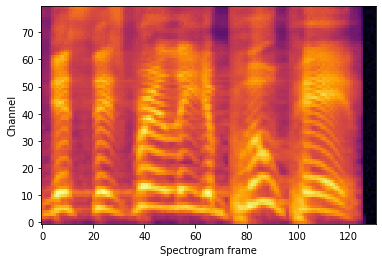

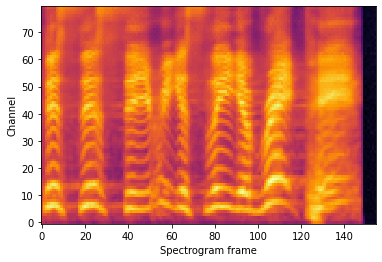

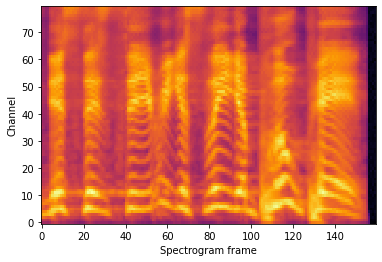

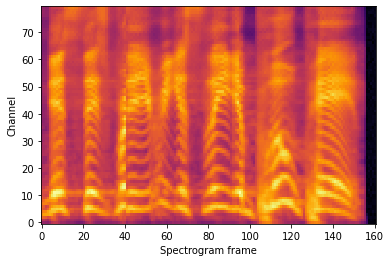

In [24]:
from uberduck_ml_dev.utils.plot import plot_spectrogram
import matplotlib.pyplot as plt

%matplotlib inline

plot_spectrogram(y_dec1.squeeze().cpu())
plt.show()
plot_spectrogram(y_dec2.squeeze().cpu())
plt.show()
plot_spectrogram(y_dec_edit.squeeze().cpu())
plt.show()
plot_spectrogram(y_dec_cat.squeeze().cpu())
plt.show()

In [25]:
ipd.Audio(audio_edit, rate=22050)

In [26]:
ipd.Audio(audio_cat, rate=22050)

In [ ]:
ipd.Audio(audio_edit, rate=22050)
# audio = torch.FloatTensor(audio_edit)
# audio = audio / max_wav_value
# audio = audio.unsqueeze(0)
# melspec_processed = stft.mel_spectrogram(audio)

# plot_spectrogram(melspec_processed.squeeze())
# plt.show()

In [ ]:
ipd.Audio(audio_cat, rate=22050)
# audio = torch.FloatTensor(audio_cat)
# audio = audio / max_wav_value
# audio = audio.unsqueeze(0)
# melspec_processed = stft.mel_spectrogram(audio)

# plot_spectrogram(melspec_processed.squeeze())
# plt.show()

In [ ]:
y_enc, y_dec, attn = model.infer(
    "The Fitness Gram Pacer Test is a multistage aerobic capacity test that progressively gets more difficult as it continues.",
    n_timesteps=100,
)
audio = hifigan.infer(y_dec)
# audio = audio / np.max(audio)
# ipd.Audio(audio, rate=22050)

In [ ]:
y_enc, y_dec, attn = model.infer(
    "The fitness gram pace test is a multi stage aerobic capacity test that { P R AH0 G R EH1 S IH0 V L IY0 } gets more difficult as it continues.",
    n_timesteps=50,
)
audio = hifigan.infer(y_dec)
audio = audio / np.max(audio)
# ipd.Audio(audio, rate=22050)

In [ ]:
y_enc, y_dec, attn = model.infer(
    "Do you say progressively or do you say { P R AH0 G R EH1 S IH0 V L IY0 }.",
    n_timesteps=50,
)
audio = hifigan.infer(y_dec)
audio = audio / np.max(audio)
ipd.Audio(audio, rate=22050)